## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda

In [3]:
import numpy as np
from numba import vectorize

@vectorize()
def vec_log(x):
    return np.log(x)

@vectorize()
def vec_exp(x):
    return np.exp(x)

A = np.array([2,5,10,3,8]).astype(np.float32)
print(vec_log(A))
print(vec_exp(A))


[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [4]:
import numpy as np
import math 
#from scipy.stats import norm
from numba import jit

@jit(nopython=True) 
def gauss_pdf(x,mu,sigma):
    return (1/sigma*np.sqrt(2*np.pi))*(np.exp(-0.5*((x-mu)/sigma)**2))

x = np.linspace(-3,3,100000).astype(np.float32)
gauss_pdf(x,1,1)

array([0.00084088, 0.00084108, 0.00084128, ..., 0.33931662, 0.33927601,
       0.33923525])

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

Text(0.5, 1.0, 'With Zero suppression')

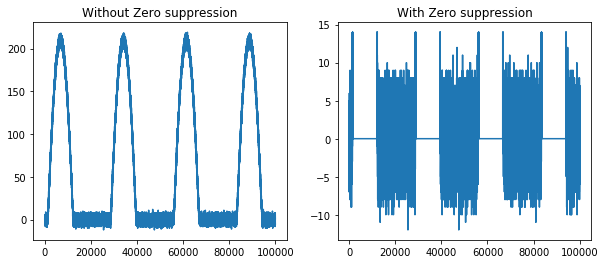

In [5]:
import matplotlib.pyplot as plt
import numpy as np
threshold = 15
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

from numba import jit
@jit 
def supp_data(threshold,data):
    x = np.where(data<threshold,data,0)
    return x
    
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(data)
plt.title("Without Zero suppression")

plt.subplot(1,2,2)
plt.plot(supp_data(threshold,data))
plt.title("With Zero suppression")


In [6]:
import numpy as np
a = np.array([1,2,3,4,5,6])
print(np.where(a<4,a,0))

[1 2 3 0 0 0]


## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [7]:
import numpy as np
import math
from numba import jit, cuda
np.random.seed(1)
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(nopython=True)
def k(matrix1,matrix2):
    res = np.array([[0 for x in range(3)] for y in range(3)]).astype(np.float64)  
  
    # explicit for loops 
    for i in range(len(matrix1)): 
        for j in range(len(matrix2[0])): 
            for k in range(len(matrix2)): 

                # resulted matrix 
                res[i][j] += matrix1[i][k] * matrix2[k][j]
            res[i][j] = math.tanh(alpha*res[i][j]+c)
    return res  

alpha = 0.5
c = 0.5
X = X.T

print(k(X,Y))


[[0.60797095 0.64049468 0.60376235]
 [0.67773201 0.65699874 0.68862212]
 [0.56658585 0.55345794 0.54563078]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [8]:
from numba import cuda, jit
import numpy
import math

# CUDA kernel
@cuda.jit()
def kernel_3D(io_array):
    x,y,z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = np.cos(io_array[x][y][z]) # do the computation

# Host code   
data = numpy.random.random((256,256,256))

# Configure the blocks
threadsperblock = (64,64,64) #ThreadsPerBlock must be a divisor of the data dimension: 256/(16x4x4) = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))

blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

kernel_3D[blockspergrid, threadsperblock](data)
print(data)

[[[0.99016193 0.98044199 0.6961724  ... 0.95005509 0.81276174 0.90886264]
  [0.56215917 0.77895362 0.98034969 ... 0.99786403 0.89969189 0.93034827]
  [0.5608783  0.98592395 0.56299789 ... 0.5549521  0.80429625 0.93047428]
  ...
  [0.64197273 0.95264479 0.9184515  ... 0.94906959 0.97234458 0.71662622]
  [0.9587155  0.96442071 0.57825775 ... 0.87673785 0.83339746 0.96307912]
  [0.9560278  0.96490123 0.71186912 ... 0.90934094 0.99988487 0.99773243]]

 [[0.94876636 0.97026211 0.99770359 ... 0.98969902 0.76776833 0.98630979]
  [0.93588688 0.92581917 0.57772738 ... 0.97713443 0.95204533 0.5513537 ]
  [0.97110839 0.97570203 0.86682358 ... 0.93753864 0.99013128 0.91521897]
  ...
  [0.7728916  0.71573008 0.88179458 ... 0.93937671 0.95243126 0.99805831]
  [0.92816861 0.9838767  0.90545197 ... 0.58103922 0.70846445 0.60159775]
  [0.98137349 0.99299957 0.57593088 ... 0.6321867  0.78841549 0.98947692]]

 [[0.95110247 0.98236388 0.69752851 ... 0.9968543  0.87613885 0.99700542]
  [0.66231596 0.943639

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [9]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp


# Initialize the data arrays
A = numpy.full((24, 12), 3, numpy.float) # matrix containing all 3's
B = numpy.full((12, 22), 4, numpy.float) # matrix containing all 4's

# Copy the arrays to the device
A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(B)

# Allocate memory on the device for the result
C_global_mem = cuda.device_array((24, 22))

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Start the kernel 
matmul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

# Copy the result back to the host
C = C_global_mem.copy_to_host()

print(C)        



[[144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 144. 144. 144. 144. 144. 144. 144.]
 [144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144. 144.
  144. 1